<a href="https://colab.research.google.com/github/neo09sumedh/BERT-LLM/blob/main/Project_Phase_2_V3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Introduction:
This project aims to develop a sentiment analysis system to assess movie reviews
using BERT, one of the most advanced language models for natural language
processing. The goal is to classify movie reviews as positive or  negative,
enabling people and business team’s data-driven decisions about movie preferences,
marketing strategies, and audience engagement. Please find below example of Sentment analysis

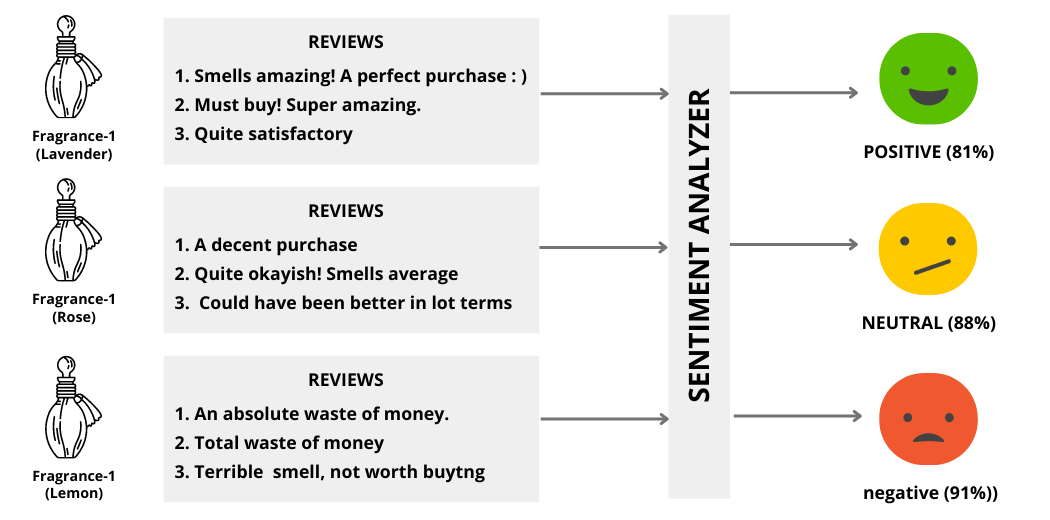

In the project we will train the model with Movie reviews data and then model would help to classify the data wif its positive or negative.

Models: BERT Sentiment Classification
Our goal is to create a model that takes a sentence and produces either 1 (indicating the sentence carries a positive sentiment) or a 0 (indicating the sentence carries a negative sentiment). As we have trained data on positive and negative dataset ,Model will  only be able to clasiffy data based on trained model.

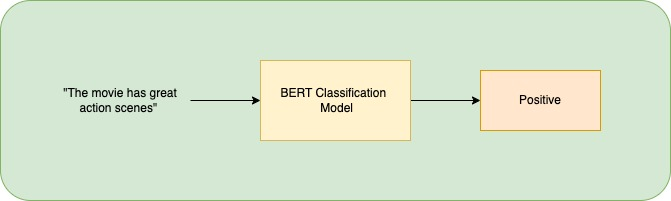

We are using model BERT porovide by Hugging face to make the model lern and we are using BertForSequenceClassification to clasify the data.

Installing the transformers library
Let's start by installing the huggingface transformers library so we can load our deep learning NLP model.

In [1]:
pip install --upgrade transformers datasets torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
  Attempting uninstall: transformers
    Found existing installation: transformers 4.46.2
    Uninstalling transformers-4.46.2:
      Successfully uninstalled transformers-4.46.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are 

## Importing Required Libraries & Dataset
Below combination of libraries supports end-to-end development of NLP tasks, from data preparation to model training and evaluation.

In [2]:
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification,DistilBertForSequenceClassification, AdamW
from transformers import get_scheduler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import pandas as pd

# Ensure you have a GPU available for faster training
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Step 1: Load and preprocess the dataset
# Example: Load a CSV dataset with 'text' and 'label' columns
df = pd.read_csv('https://github.com/clairett/pytorch-sentiment-classification/raw/master/data/SST2/train.tsv', delimiter='\t', header=None)  # Replace with your dataset
texts = df[0].tolist()
labels = df[1].tolist()

## Text Preprocessing
Below code will clean the movie reviews by removing all non required characters and whitespaces. Basically it will hold only characters that are good for training the model.

In [3]:
import re
def preprocess_string(s):
    # Convert to lowercase (optional, depending on the task)
    s = s.lower()
    # Remove unnecessary special characters (but retain punctuation)
    s = re.sub(r"[^\w\s.,!?]", '', s)
    # Replace extra spaces with a single space
    s = re.sub(r"\s+", ' ', s).strip()
    return s

##Text Tokenizer.
The BertTokenizer is responsible for preprocessing text to prepare it for input into BERT . It performs several key activities:
1) Tokenization
2) Adding Special Tokens
3) Mapping Tokens to IDs

In [4]:
# Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

#Embedding
Below code will perfom emedding and add padding to the data. Once data is padded it tell model which is actual text and also provide the details on Attention masking which tells model what data is masked.

In [5]:
# Dataset Preparation
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'label': torch.tensor(label, dtype=torch.long)
        }

#Prepare Dataset
Prepare dataset consumed by the model.We need to perfom the train_test_split allow model to get train on the train data and get it validated with test data. Also we are creating batch for the data using dataloder that can be passed to model in batches.

In [6]:
#Call inline function to clean the text
texts = [preprocess_string(text) for text in texts]
#Perfom text test split for getting train and test data.
train_texts, test_texts, train_labels, test_labels = train_test_split(
    texts, labels, test_size=0.2, random_state=42
)


train_dataset = SentimentDataset(train_texts, train_labels, tokenizer)
test_dataset = SentimentDataset(test_texts, test_labels, tokenizer)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Actual Model
We are BERT for classification of the data based on the inputs. In our case we have movie review and sentiments as positive and negative that allows model to get train. We will be using train model 'bert-base-uncased' provided by Huggingface. Below is architecture how BERT works.  

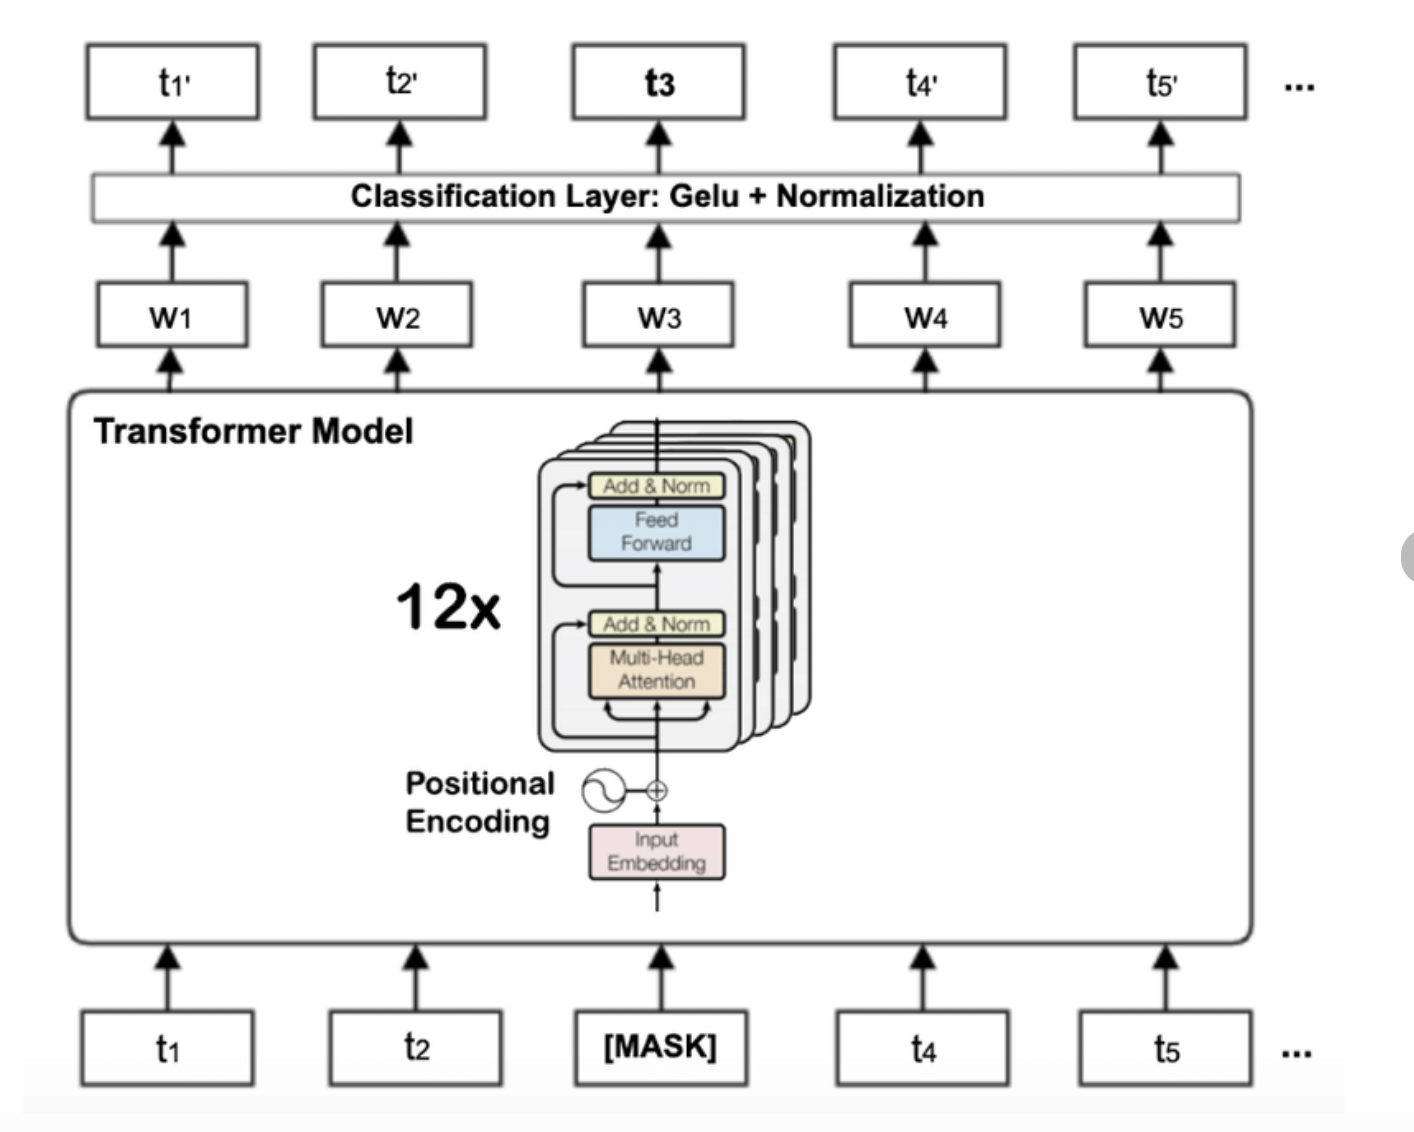

BERT is based on the paper "Attention is all you need" . In this paper its been described the BERT uses encoder for perfoming training of the model. As you can see in above architecture t1 to t5 are inputs which is been passed to embedding. Here inputs are added with special tokens known as CLS and SEP. SEP is seprater and CLS is Special token use to store token ID for entire sentence which is used by model while training. Input is been passed to positional endocding were position of each word is been maintained. Multi head attention is used to calculating the loss and backpropogation for adjusting weights to reduce the loss.Feed Forward is used to send output for identfying next sequence/masking and using softmax layer output can be identified which has responsiblity to convert the probablites to actual word.

#Explaining the Model.
In this code we are using BertForSequenceClassification class from model bert-base-uncased. BertForSequenceClassfication model specifically designed for sequence classification tasks, such as sentiment analysis, spam detection, or intent classification.We are using AdamW as optimizer algorithm which perform adptive learning and avoids over weight decay that means avoiding the large weights that help from overfitting the model.To control the rate at which the model learns we are using Schedular. Schedular decides how fast or how slow the model should learn. In this code we are using the 4 epoch that means the model will run for 4 iterations to calcuate loss and and propogate backward for adjusting the weights to reduce those losses. At every epoch we will optimize the weights and schedular to make model learn. We perform similar exercise with test data as well that will help us to understand how close are we on our objective.

##LOSS Calculation
The below graph will help you to learn how well the model is been trained. We have plot the losses from training dataset as well test dataset for all the 4 epochs . Each epoch has reduced the losses and made model well trained on given data set.Low the losses on both dataset ideally means we have avoided overfitting or underfitting of the model.

In [7]:
import numpy as np
# Step 2: Load BERT Model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)  # Adjust num_labels based on classes
model.to(device)

# Step 3: Optimizer and Scheduler
optimizer = AdamW(model.parameters(), lr=5e-5)
num_training_steps = len(train_loader) * 4  # Assume 4 epochs
scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

# Loss Function
loss_fn = torch.nn.CrossEntropyLoss()
epoch_tr_loss,epoch_test_loss = [],[]
train_losses = []
train_acc = 0.0
# Step 4: Training Loop
epochs = 4
model.train()
for epoch in range(epochs):
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        train_losses.append(loss.item())

        loss.backward()
        optimizer.step()
        scheduler.step()

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(train_loader)}")
    test_losses = []
    test_acc = 0.0
    total_test_loss = 0
    for batch in test_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_test_loss += loss.item()
        test_losses.append(loss.item())

        loss.backward()
        optimizer.step()
        scheduler.step()
    print(f"Epoch Test {epoch + 1}/{epochs}, Loss: {total_test_loss / len(test_loader)}")
    epoch_tr_loss.append(np.mean(train_losses))
    epoch_test_loss.append(np.mean(test_losses))
# Step 5: Evaluation
model.eval()
predictions, true_labels = [], []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)

        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())
        #accuracy = accuracy_score(predictions, true_labels)
        #print(f"Accuracy: {accuracy}")

print(classification_report(true_labels, predictions, target_names=["Negative", "Positive"]))

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/4, Loss: 0.3926974876724571
Epoch Test 1/4, Loss: 0.258880413383588
Epoch 2/4, Loss: 0.13143905866998812
Epoch Test 2/4, Loss: 0.07295202006232636
Epoch 3/4, Loss: 0.027881936267061386
Epoch Test 3/4, Loss: 0.01751169400964061
Epoch 4/4, Loss: 0.00805045681369001
Epoch Test 4/4, Loss: 0.009513587230580977
              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00       671
    Positive       1.00      1.00      1.00       713

    accuracy                           1.00      1384
   macro avg       1.00      1.00      1.00      1384
weighted avg       1.00      1.00      1.00      1384



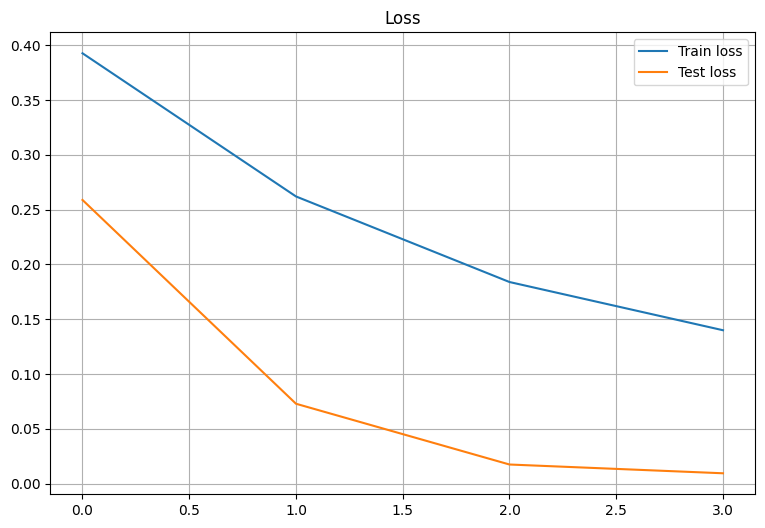

In [8]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_loss, label='Train loss')
plt.plot(epoch_test_loss, label='Test loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()


##Save the Trained Model
Once the model is trained on dataset,We can save this model for further use for predication or classficatiion of the data.

In [9]:
model.save_pretrained("bert-sentiment")
tokenizer.save_pretrained("bert-sentiment")


('bert-sentiment/tokenizer_config.json',
 'bert-sentiment/special_tokens_map.json',
 'bert-sentiment/vocab.txt',
 'bert-sentiment/added_tokens.json')

#Validate the Results
Below code will help you to predict the classfication class like if the sentence is positive or negative. We are utilizing the model which we have saved in previous step and passing it text to perform the classfication. As you can see the model provides logit(raw, unnormalized outputs produced by a model) as output which is given to last layer that activation layer known as softmax which give the probablity of the word or class identfied. Once the class or word is identfied its been provided as output as prediction.

In [10]:
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer

model = BertForSequenceClassification.from_pretrained("bert-sentiment")
tokenizer = BertTokenizer.from_pretrained("bert-sentiment")
model.to(device)

# Inference Function
def predict_sentiment(text, model, tokenizer):
    model.eval()
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    inputs = {key: val.to(device) for key, val in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probabilities = torch.softmax(logits, dim=-1)
        predicted_label = torch.argmax(probabilities, dim=-1).item()

    # Label mapping
    label_map = {0: "Negative", 1: "Positive"}
    sentiment = label_map[predicted_label]
    return sentiment, probabilities.cpu().numpy()

# Example usage
texts = [
    "Movie had good start cast!",
    "This is the worst experience with movie.",
    "Movie is great",
    "I hate screen"
]

for text in texts:
    sentiment, probabilities = predict_sentiment(text, model, tokenizer)
    print(f"Text: {text}\nSentiment: {sentiment}\nProbabilities: {probabilities}\n")


Text: Movie had good start cast!
Sentiment: Positive
Probabilities: [[4.2494808e-04 9.9927217e-01 3.0290618e-04]]

Text: This is the worst experience with movie.
Sentiment: Negative
Probabilities: [[9.9840015e-01 8.6533499e-04 7.3449349e-04]]

Text: Movie is great
Sentiment: Positive
Probabilities: [[3.1384808e-04 9.9931955e-01 3.6660762e-04]]

Text: I hate screen
Sentiment: Negative
Probabilities: [[9.9834430e-01 1.2572671e-03 3.9845434e-04]]

